<a href="https://colab.research.google.com/github/popoviclazar13/CarObjectDetection/blob/main/CarObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Student**: Popovic Lazar IT64/2020
#**Tema**: Detekcija automobila na slici
#**Predmet**: Principi prezentacije i prepoznavanja oblika

# **Uvod**
Detekcija objekata je kompjuterska tehnologija povezana sa kompjuterskim vidom i obradom slika koja se bavi otkrivanjem instanci semantičkih objekata određene klase (kao što su ljudi, zgrade ili automobili) u digitalnim slikama i video zapisima. Dobro istraženi domeni detekcije objekata uključuju detekciju lica i pešaka. Detekcija objekata ima primenu u mnogim oblastima kompjuterskog vida, uključujući pronalaženje slika i video nadzor.

# **Upotreba**

Široko se koristi u zadacima kompjuterskog vida kao što su beleške na slici, brojanje vozila, prepoznavanje aktivnosti, prepoznavanje lica. Takođe se koristi za praćenje objekata, na primer praćenje lopte tokom fudbalske utakmice, praćenje kretanja palice za kriket ili praćenje osobe na video snimku.

Često se testne slike uzorkuju iz različite distribucije podataka, što znatno otežava zadatak otkrivanja objekata. Da bi se rešili izazovi izazvani jazom u domenu između podataka o obuci i testiranju, predloženi su mnogi pristupi prilagođavanju domena bez nadzora. Jednostavno i direktno rešenje za smanjenje jaza u domenu je primena pristupa prevođenja slike u sliku, kao što je ciklus-GAN. Između ostalih upotreba, detekcija objekata u više domena se primenjuje u autonomnoj vožnji, gde se modeli mogu obučiti na ogromnom broju scena video igara, pošto se oznake mogu generisati bez ručnog rada.

In [ ]:
!unzip /content/drive/MyDrive/Car_Object_Detection.zip

Archive:  /content/drive/MyDrive/Car_Object_Detection.zip
  inflating: data/sample_submission.csv  
  inflating: data/testing_images/vid_5_25100.jpg  
  inflating: data/testing_images/vid_5_25120.jpg  
  inflating: data/testing_images/vid_5_25140.jpg  
  inflating: data/testing_images/vid_5_25160.jpg  
  inflating: data/testing_images/vid_5_25180.jpg  
  inflating: data/testing_images/vid_5_25200.jpg  
  inflating: data/testing_images/vid_5_25220.jpg  
  inflating: data/testing_images/vid_5_25240.jpg  
  inflating: data/testing_images/vid_5_25260.jpg  
  inflating: data/testing_images/vid_5_26320.jpg  
  inflating: data/testing_images/vid_5_26400.jpg  
  inflating: data/testing_images/vid_5_26420.jpg  
  inflating: data/testing_images/vid_5_26560.jpg  
  inflating: data/testing_images/vid_5_26580.jpg  
  inflating: data/testing_images/vid_5_26600.jpg  
  inflating: data/testing_images/vid_5_26620.jpg  
  inflating: data/testing_images/vid_5_26640.jpg  
  inflating: data/testing_images/

# **Postavka**
Importovanje potrebnihbiblioteka

In [ ]:
# Za manipulisanje podataka
import numpy as np
import pandas as pd

# Vizuelizacija i obrada slike
import cv2
import matplotlib.pyplot as plt

# masinsko ucenje
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Input, BatchNormalization, Flatten, MaxPool2D, Dense

from pathlib import Path

In [ ]:
#podesavanje putanja
train_path = Path("/content/data/training_images")
test_path = Path("/content/data/testing_images")

In [ ]:
#ucitavanje csv fajla
train = pd.read_csv("/content/data/train_solution_bounding_boxes (1).csv")
train[['xmin', 'ymin', 'xmax', 'ymax']] = train[['xmin', 'ymin', 'xmax', 'ymax']].astype(int)
train.drop_duplicates(subset='image', inplace=True, ignore_index=True)

Kreiranje funkcije za laksi prikaz slike

In [ ]:
def display_image(img, bbox_coords=[], pred_coords=[], norm=False):
    if norm:
        img *= 255.
        img = img.astype(np.uint8)

    # crtanje pravugaonika
    if len(bbox_coords) == 4:
        xmin, ymin, xmax, ymax = bbox_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (0, 255, 0), 3)

    if len(pred_coords) == 4:
        xmin, ymin, xmax, ymax = pred_coords
        img = cv2.rectangle(img, (int(xmin), int(ymin)), (int(xmax), int(ymax)), (255, 0, 0), 3)

    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])

def display_image_from_file(name, bbox_coords=[], path=train_path):
    img = cv2.imread(str(path/name))
    display_image(img, bbox_coords=bbox_coords)

def display_from_dataframe(row, path=train_path):
    display_image_from_file(row['image'], bbox_coords=(row.xmin, row.ymin, row.xmax, row.ymax), path=path)


def display_grid(df=train, n_items=3):
    plt.figure(figsize=(20, 10))

    # uzima 3 random slike i formira grid 1x3
    rand_indices = [np.random.randint(0, df.shape[0]) for _ in range(n_items)]

    for pos, index in enumerate(rand_indices):
        plt.subplot(1, n_items, pos + 1)
        display_from_dataframe(df.loc[index, :])

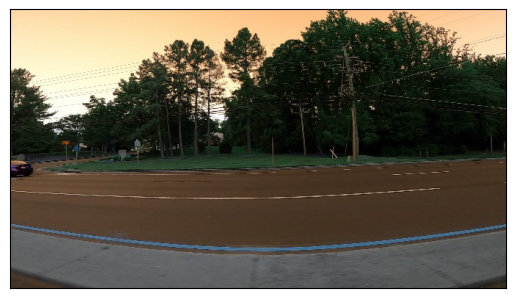

In [ ]:
display_image_from_file("vid_4_10520.jpg")

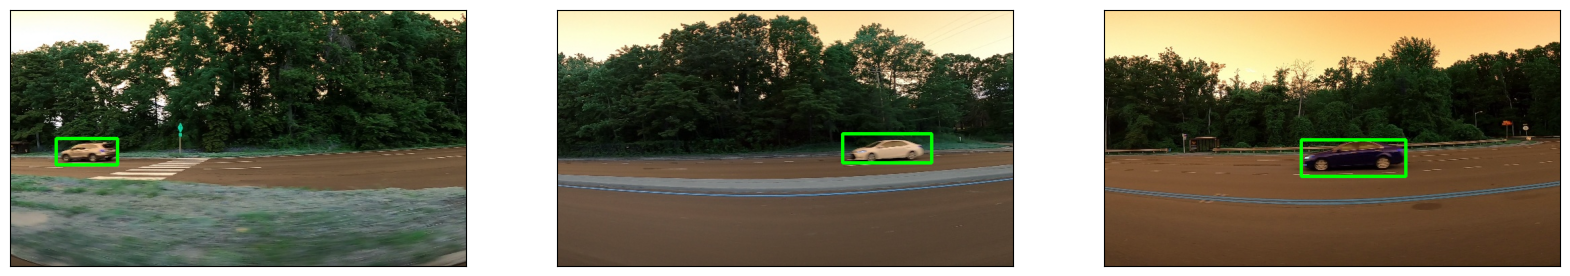

In [ ]:
display_grid()

# **Treniranje modela**


In [ ]:
def data_generator(df=train, batch_size=16, path=train_path):
    while True:
        images = np.zeros((batch_size, 380, 676, 3))
        bounding_box_coords = np.zeros((batch_size, 4))

        for i in range(batch_size):
                rand_index = np.random.randint(0, train.shape[0])
                row = df.loc[rand_index, :]
                images[i] = cv2.imread(str(train_path/row.image)) / 255.
                bounding_box_coords[i] = np.array([row.xmin, row.ymin, row.xmax, row.ymax])

        yield {'image': images}, {'coords': bounding_box_coords}

daje prikaz random slike na kojoj je detektovan automobil

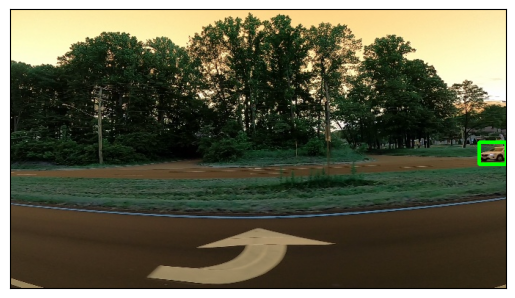

In [ ]:
example, label = next(data_generator(batch_size=1))
img = example['image'][0]
bbox_coords = label['coords'][0]

display_image(img, bbox_coords=bbox_coords, norm=True)

# **Kreiranje modela**

In [ ]:
input_ = Input(shape=[380, 676, 3], name='image')

x = input_

for i in range(10):
    n_filters = 2**(i + 3)
    x = Conv2D(n_filters, 3, activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPool2D(2, padding='same')(x)

x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dense(32, activation='relu')(x)
output = Dense(4, name='coords')(x)

model = tf.keras.models.Model(input_, output)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 380, 676, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 380, 676, 8)       224       
                                                                 
 batch_normalization (Batch  (None, 380, 676, 8)       32        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 190, 338, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 190, 338, 16)      1168      
                                                                 
 batch_normalization_1 (Bat  (None, 190, 338, 16)      64    

In [ ]:
model.compile(
    loss={
        'coords': 'mse'
    },
    optimizer=tf.keras.optimizers.Adam(1e-3),
    metrics={
        'coords': 'accuracy'
    }
)

kreiranje funkcije za testiranje modela

In [ ]:
def test_model(model, datagen):
    example, label = next(datagen)

    X = example['image']
    y = label['coords']

    pred_bbox = model.predict(X)[0]

    img = X[0]
    gt_coords = y[0]

    display_image(img, pred_coords=pred_bbox, norm=True)

def test(model):
    datagen = data_generator(batch_size=1)

    plt.figure(figsize=(15,7))
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        test_model(model, datagen)
    plt.show()

class ShowTestImages(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        test(self.model)

1/1 [==============================] - 0s 227ms/step


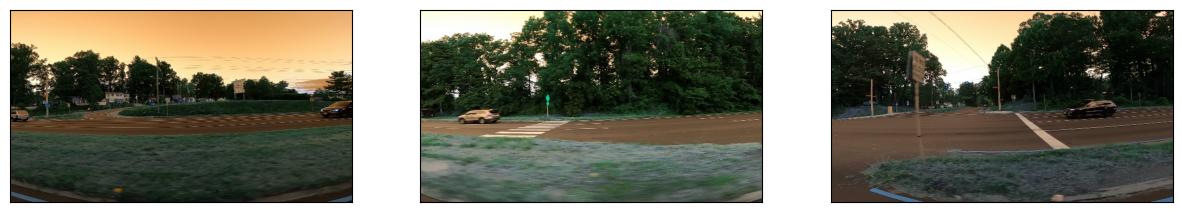

In [ ]:
test(model)

Epoch 1/9
1/1 [==============================] - 0s 165ms/step


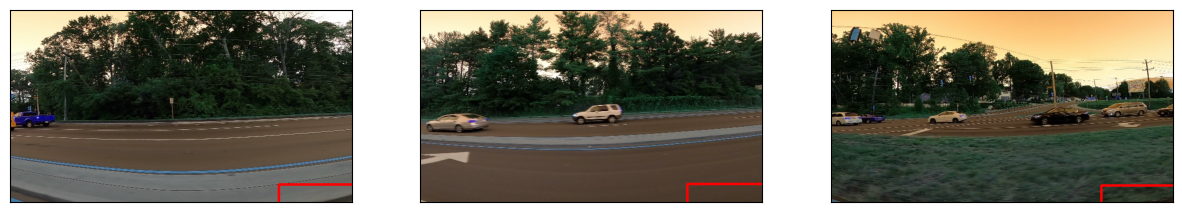

20/20 [==============================] - 723s 36s/step - loss: 41953.0078 - accuracy: 0.5125
Epoch 2/9
1/1 [==============================] - 0s 451ms/step


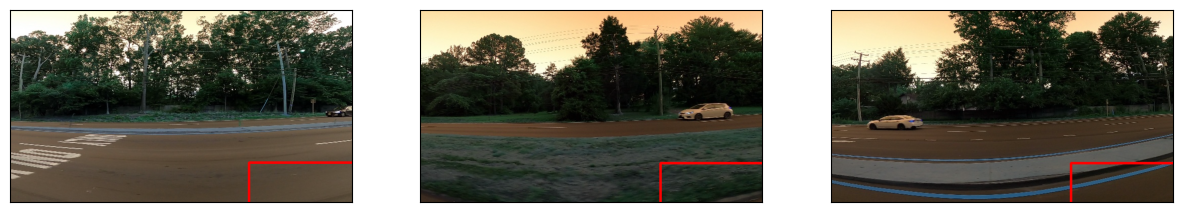

20/20 [==============================] - 765s 38s/step - loss: 14933.7998 - accuracy: 0.5688
Epoch 3/9
1/1 [==============================] - 0s 201ms/step


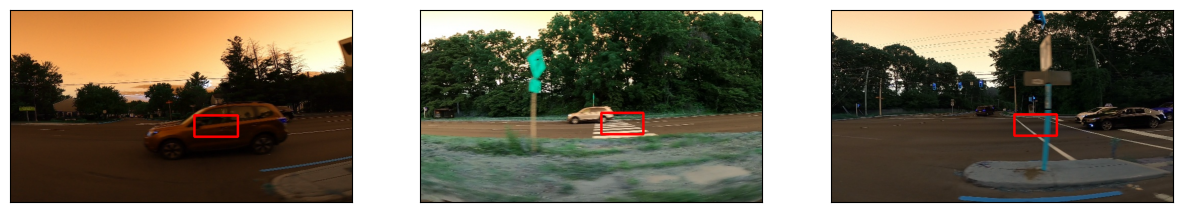

20/20 [==============================] - 794s 40s/step - loss: 12240.1240 - accuracy: 0.5844
Epoch 4/9
1/1 [==============================] - 0s 174ms/step


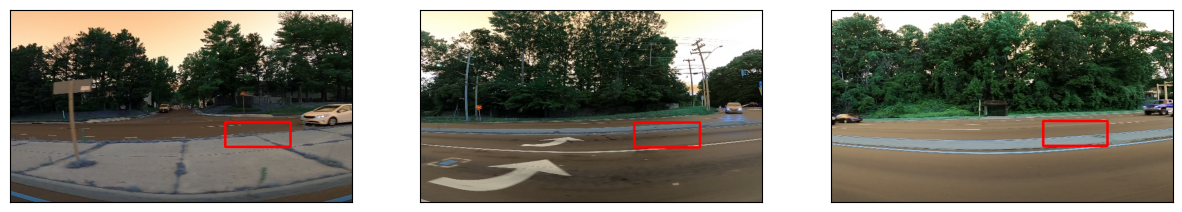

20/20 [==============================] - 857s 43s/step - loss: 9939.7012 - accuracy: 0.7844
Epoch 5/9
1/1 [==============================] - 0s 169ms/step


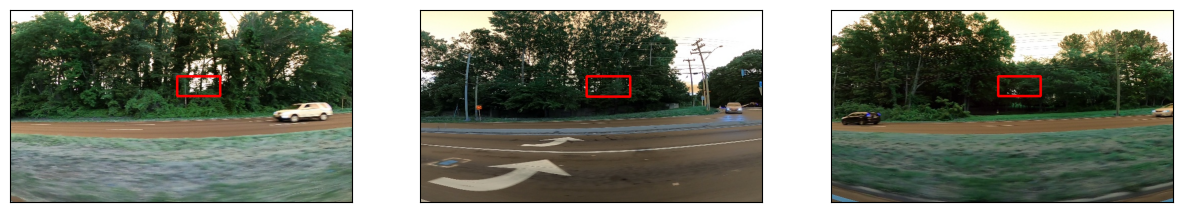

20/20 [==============================] - 784s 39s/step - loss: 4315.3325 - accuracy: 0.8813
Epoch 6/9
1/1 [==============================] - 0s 217ms/step


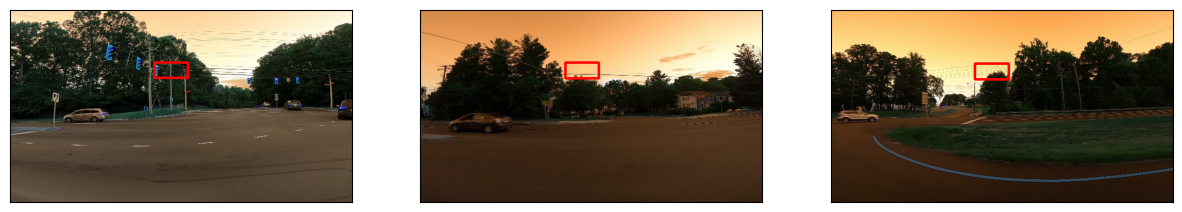

20/20 [==============================] - 774s 39s/step - loss: 3155.7891 - accuracy: 0.9031
Epoch 7/9
1/1 [==============================] - 0s 171ms/step


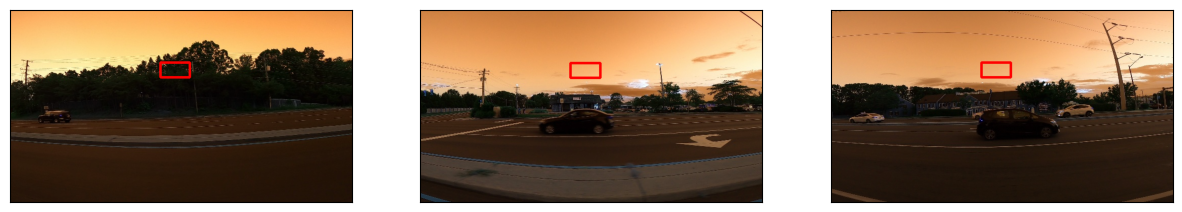

20/20 [==============================] - 770s 39s/step - loss: 3494.7886 - accuracy: 0.9281
Epoch 8/9
1/1 [==============================] - 0s 174ms/step


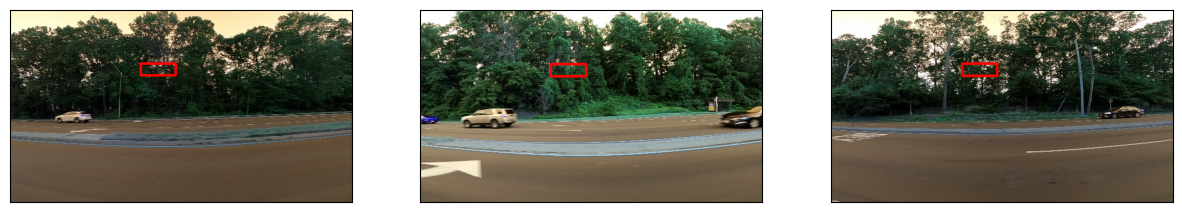

20/20 [==============================] - 791s 40s/step - loss: 3805.5684 - accuracy: 0.9187
Epoch 9/9
1/1 [==============================] - 0s 205ms/step


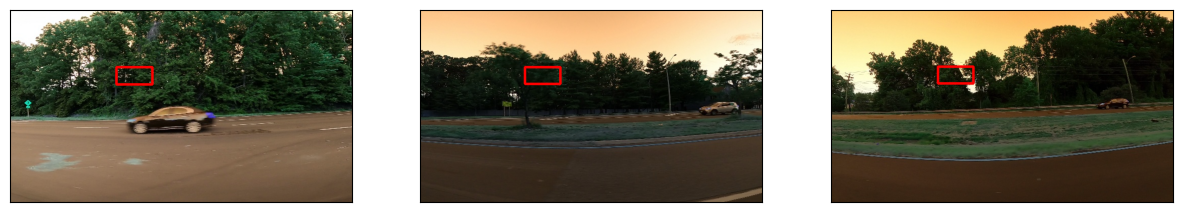

20/20 [==============================] - 777s 39s/step - loss: 4806.6729 - accuracy: 0.9094


In [ ]:
with tf.device('/GPU:0'):
    _ = model.fit(
        data_generator(),
        epochs=9,
        steps_per_epoch=20,
        callbacks=[
            ShowTestImages(),
        ]
    )